In [76]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import matplotlib.pyplot as py
from astropy import units as u_sci
import cmbdb as cmb


In [77]:
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.component_model import CMB, Dust, Synchrotron
from fgbuster.separation_recipes import standardize_instrument, _intersect_mask,_get_prewhiten_factors,_A_evaluator,_get_alms,_format_alms,_r_to_c_alms

import fgbuster.algebra as alg
from fgbuster.observation_helpers import get_instrument,get_noise_realization,get_sky,get_observation
from fgbuster.cosmology import _get_Cl_noise
from fgbuster.separation_recipes import harmonic_comp_sep, basic_comp_sep

In [78]:
import os
import platform

print("Name:        ", os.name)
print("System:      ", platform.system())
print("Release:     ", platform.release())
print("Architecture:", platform.architecture())
print("Machine:     ", platform.machine())
print("Processor:   ", platform.processor())
print("Release:     ", platform.release())
print("Version:     ", platform.version())

# On Windows:
# nt
# Windows
# 10


if platform.system() != 'Windows':
    print("Uname:       ", os.uname())

# On Windows uname is not available

Name:         posix
System:       Linux
Release:      3.10.0-1127.el7.x86_64
Architecture: ('64bit', 'ELF')
Machine:      x86_64
Processor:    x86_64
Release:      3.10.0-1127.el7.x86_64
Version:      #1 SMP Tue Mar 31 23:36:51 UTC 2020
Uname:        posix.uname_result(sysname='Linux', nodename='ansys06', release='3.10.0-1127.el7.x86_64', version='#1 SMP Tue Mar 31 23:36:51 UTC 2020', machine='x86_64')


In [79]:
%config Completer.use_jedi = False

In [80]:
uK_RJ2uK_CMB = 1* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(300.0 * u.GHz))
a = uK_RJ2uK_CMB
print(uK_RJ2uK_CMB)

6.983704969016967


In [81]:
def D_ell(C_ell):
    # Determine the length of the input power spectrum
    n_ell = len(C_ell)

    # Create an array of zeros to store the scale invariant power spectrum
    D_ell = np.zeros(n_ell)

    # Compute the scale invariant power spectrum using vectorized operations
    # Vectorized operations eliminate the need for a for loop, improving performance

    # Compute the product of each element with the next element using np.arange(n_ell) * (np.arange(n_ell) + 1)
    # Multiply the above result by C_ell to perform element-wise multiplication with the corresponding elements in C_ell
    # Divide the above result by np.pi to perform element-wise division by pi
    D_ell = np.arange(n_ell) * (np.arange(n_ell) + 1) * C_ell / np.pi

    # Return the computed scale invariant power spectrum
    return D_ell

In [82]:
amin2rad = np.pi/(60.*180.)

# Simulating Sky

In [83]:
NSIDE = 512
NSIDE_decon = 128
# lmax = 3*NSIDE-1  # Maximum ell value based on the given NSIDE value
lmax = 2*NSIDE
lmax_decon = 2*NSIDE_decon
sky_d0s0 = get_sky(NSIDE, 'd0s0')  # Get the sky map using the specified NSIDE and sky type 'd0s0'

instrument = get_instrument('LiteBIRD')  # Get the instrument information for 'LiteBIRD'
freq_maps_d0s0 = get_observation(instrument, sky_d0s0)
# freq_maps_d0s0 = np.zeros(freq_maps_d0s0.shape)
# Obtain the frequency maps for the given instrument and sky map.
# freq_maps_d0s0 is a 3D array containing the observed maps for each frequency channel.

num_freq, ncomp, npix = freq_maps_d0s0.shape
# Retrieve the dimensions of the freq_maps_d0s0 array.
# - num_freq represents the number of frequency channels.
# - ncomp represents the number of components in the observed map.
# - npix represents the number of pixels in the observed map.

/home/julientang2001/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


In [84]:
print(instrument.fwhm)

0     70.5
1     58.5
2     51.1
3     47.1
4     43.8
5     41.5
6     37.8
7     33.6
8     30.8
9     28.9
10    28.6
11    24.7
12    22.5
13    20.9
14    17.9
Name: fwhm, dtype: float64


In [85]:
# instrument.fwhm = np.zeros(15)
print(instrument.fwhm)

0     70.5
1     58.5
2     51.1
3     47.1
4     43.8
5     41.5
6     37.8
7     33.6
8     30.8
9     28.9
10    28.6
11    24.7
12    22.5
13    20.9
14    17.9
Name: fwhm, dtype: float64


In [86]:
cl_CMB_th = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_lensed_scalar.fits")

cl_CMB_crop_th = cl_CMB_th[:,:lmax+1]

np.random.seed(0)
map_CMB = hp.synfast(cl_CMB_th,nside=NSIDE,new = True)


print(map_CMB.shape)
cl_CMB6 = hp.anafast(map_CMB,lmax=lmax,alm = False)
cl_CMB = cl_CMB6[:4]
print(cl_CMB.shape)

(3, 3145728)
(4, 1025)


In [87]:
# freq_maps_simple_noiseless1 = np.array([np.add(map_CMB,map_d0s0) for map_d0s0 in freq_maps_d0s0])
freq_maps_simple_noiseless2 = map_CMB+freq_maps_d0s0

In [88]:
# np.where(freq_maps_simple_noiseless1-freq_maps_simple_noiseless2!=0)

In [89]:
beam_array = np.array([hp.gauss_beam(f*amin2rad,lmax = lmax, pol=True) for f in instrument.fwhm])
print(beam_array.shape)

(15, 1025, 4)


In [90]:
inv_beam_arr = 1./beam_array
fwhm_common = 80*amin2rad
beam_common = hp.gauss_beam(fwhm_common,lmax = lmax, pol = True)
b_c = np.array([beam_common*beam_inv for beam_inv in inv_beam_arr])
print(b_c.shape)

(15, 1025, 4)


In [91]:
print(inv_beam_arr*beam_array)

[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


## Beam (check with hp.smoothing)

In [92]:
map_CMB_smooth = np.array([hp.smoothing(map_CMB[j,:],fwhm = fwhm_common,pol=True) for j in range(0,ncomp)])
print(map_CMB_smooth.shape)

map_CMB_smooth_QU =map_CMB_smooth[1:3]
print(map_CMB_smooth_QU.shape)

cl_CMB_smooth = hp.anafast(map_CMB_smooth,lmax=lmax,alm=False)

alm_CMB_smooth = hp.map2alm(map_CMB_smooth,lmax)

(3, 3145728)
(2, 3145728)


Transform you sky map (CMB + fg) in alm


In [93]:
sky_alm = np.array([hp.map2alm(sky_map,lmax) for sky_map in freq_maps_simple_noiseless2])

In [94]:
print(sky_alm.shape)
print(beam_array.shape)

(15, 3, 525825)
(15, 1025, 4)


Power spectra

In [95]:
# Cl_simple = hp.anafast(freq_maps_simple_noiseless2[0],lmax=lmax,alm=False)

In [96]:
# from fgbuster.separation_recipes import _get_alms

In [97]:
ell = hp.Alm.getlm(lmax, np.arange(sky_alm.shape[-1]))[0]

# ell = np.stack((ell, ell), axis=-1).reshape(-1) # For transformation into real alms
#mask_lmin = [l < lmin for l in ell]

beam_array_lm = beam_array[:,ell,:]
print(beam_array_lm.shape)
beam_common_lm = beam_common[ell,:]
inv_beam_arr_lm = 1/beam_array_lm
b_c_lm = np.array([beam_common_lm*beam_inv for beam_inv in inv_beam_arr_lm])
print(b_c_lm.shape)
print(inv_beam_arr_lm.shape)

(15, 525825, 4)
(15, 525825, 4)
(15, 525825, 4)


#### Beaming maps
We want to compute $(B \ast As)_p$.
We start with convolution of the noiseless signal.

In [98]:
BAS_p_nl_smooth1 = np.array([np.array([hp.smoothing(freq_maps_simple_noiseless2[i,j],fwhm = instrument.fwhm[i]*amin2rad ,pol=True) for j in range(0,ncomp) ]) for i in range(0,num_freq)])
BAS_alm_nl_smooth = np.array([np.array([hp.almxfl(sky_alm[i,j],beam_array[i,:,j] )for j in range(0,ncomp) ]) for i in range(0,num_freq)])
print(BAS_alm_nl_smooth.shape)


(15, 3, 525825)


In [99]:
BAS_alm_nl_smooth_1 = np.array([hp.map2alm(BAS_p,lmax) for BAS_p in BAS_p_nl_smooth1])
print(np.max(BAS_alm_nl_smooth-BAS_alm_nl_smooth_1))

(0.00760109087884514-0.0007894334298597094j)


In [100]:
# print(freq_maps_simple_noiseless1.shape)
# Cl_smooth = hp.anafast(BAS_p_nl_smooth[0],lmax = lmax,alm=False)

In [101]:
AS_alm_inv2 = np.array([np.array([BAS_alm_nl_smooth[i,j]*inv_beam_arr_lm[i,:,j] for j in range(0,ncomp) ]) for i in range(0,num_freq)])
AS_alm_inv = np.array([np.array([hp.almxfl(BAS_alm_nl_smooth[i,j],inv_beam_arr[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])



In [102]:
def frac_diff(a,b):
    return(np.linalg.norm(a-b)/np.linalg.norm(b))

In [103]:
print(frac_diff(AS_alm_inv,sky_alm))

1.0241875467653276e-16


In [104]:
print(frac_diff(BAS_alm_nl_smooth_1,BAS_alm_nl_smooth))

6.692147873692484e-06


In [105]:
print(frac_diff(AS_alm_inv,AS_alm_inv2))

0.0


In [31]:
# AS_alm_ren2= np.array([np.array([BAS_alm_nl_smooth[i,j]*b_c_lm[i,:,j] for j in range(0,ncomp) ]) for i in range(0,num_freq)])
# AS_alm_ren = np.array([np.array([hp.almxfl(BAS_alm_nl_smooth[i,j],b_c[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

# print(frac_diff(AS_alm_ren,AS_alm_ren2))

In [33]:
# Cl_unsmooth = hp.anafast(AS_p_inv[0],lmax = lmax,alm=False)
# print(Cl_unsmooth.shape)

In [106]:
print(beam_common.shape)
# print(Cl_simple.shape)
print(cl_CMB_crop_th.shape)
print(beam_array.shape)

(1025, 4)
(4, 1025)
(15, 1025, 4)


In [107]:
print(AS_alm_inv.shape)
# print(AS_alm_ren.shape)


(15, 3, 525825)


Finally go back to map using alm2map and that's where you go to your desired lower nside i.e. alm2map(PreProcessedMap, NSIDE_OUT)

In [108]:
AS_p_inv = np.array([hp.alm2map(alm_inv,nside=NSIDE) for alm_inv in AS_alm_inv])
# AS_p_ren = np.array([hp.alm2map(alm_ren,nside=NSIDE) for alm_ren in AS_alm_ren])
BAS_p_nl =  np.array([hp.alm2map(alm_BAS,nside=NSIDE) for alm_BAS in BAS_alm_nl_smooth])

In [109]:
lmax_decon = 2*NSIDE_decon

In [110]:
degraded_map_input = np.array([hp.ud_grade(sky_map,nside_out=NSIDE_decon) for sky_map in freq_maps_simple_noiseless2])

In [111]:
print(degraded_map_input.shape)
print(AS_p_inv.shape)

(15, 3, 196608)
(15, 3, 3145728)


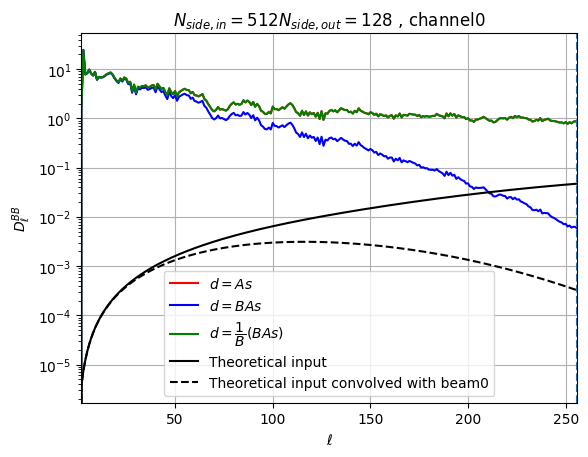

In [112]:
l_arr = np.arange(0,lmax_decon+1)
# fname = '/home/julientang2001/Stage3A/Noiseless/N_side_out_corrected/'
# for i in range(num_freq):
i = 0
Cl_simple = hp.anafast(freq_maps_simple_noiseless2[i],lmax=lmax_decon,alm=False)
Cl_smooth = hp.anafast(BAS_p_nl[i],lmax = lmax_decon,alm=False)
Cl_unsmooth = hp.anafast(AS_p_inv[i],lmax = lmax_decon,alm=False)   
Cl_sky_alm = hp.alm2cl(sky_alm[i],lmax=lmax_decon)
py.plot(l_arr,D_ell(Cl_simple[2]),'r',label = '$d=As$')
py.plot(l_arr,D_ell(Cl_smooth[2]),'b',label = '$d=BAs$')
py.plot(l_arr,D_ell(Cl_unsmooth[2]),'g',label = '$d=\dfrac{1}{B}(BAs)$')
# py.plot(l_arr,D_ell(Cl_sky_alm[2]),'g--',label = r'From sky $a_{\ell m}$')

py.plot(l_arr,D_ell(cl_CMB_crop_th[2,:lmax_decon+1]),'k',label = 'Theoretical input')
py.plot(l_arr,D_ell(cl_CMB_crop_th[2,:lmax_decon+1]*beam_array[i,:lmax_decon+1,2]**2),'k--',label = 'Theoretical input convolved with beam'+str(i))
# py.plot(l_arr,Cl_unsmooth[2]/Cl_simple[2],'c',label = '$d=\dfrac{1}{B}(BAs)$')
# py.plot(l_arr,Cl_unsmooth[2]/Cl_sky_alm[2],'m',label = '$d=\dfrac{1}{B}(BAs)$')

ax = py.gca() 
ax.axvline(2*NSIDE_decon, linestyle='--')
py.legend(loc = 'best')
#     # Set axis labels
py.xlabel('$\ell$')
py.ylabel('$D_{\ell}^{BB}$')
py.yscale('log')
py.xlim(left = 2, right = lmax_decon)
py.grid()
py.title(r'$N_{side,in}=$'+str(NSIDE)+r'$N_{side,out}=$'+str(NSIDE_decon)+' , channel' + str(i))
# py.savefig(fname + 'channel'+str(i)+'Nside_out'+str(NSIDE_decon))
# py.clf()
py.show()

In [113]:
# np.linalg.norm(AS_p_inv - freq_maps_simple_noiseless1) / np.linalg.norm(freq_maps_simple_noiseless1)

## Component separation

In [114]:
components = [CMB(), Dust(353.), Synchrotron(23.)]

In [115]:
# The starting point of the fit is the pysm default value, so let's shift it
components[1].defaults = [1.54, 20.]
components[2].defaults = [-3.0]

In [116]:
result_basic_inv= basic_comp_sep(components, instrument, AS_p_inv[:,1:3,:], # verbose output                        
                       )  ## noiseless
# result_basic_ren = basic_comp_sep(components, instrument,AS_p_ren[:,1:3,:] # verbose output             
#                                )


In [117]:
print(result_basic_inv.s.shape)
result_harmo_inv= harmonic_comp_sep(components, instrument, AS_p_inv,nside=NSIDE,lmax=lmax # verbose output                        
                       )  ## noiseless
# result_harmo_ren = harmonic_comp_sep(components, instrument, AS_p_ren,nside=NSIDE,lmax=lmax  # verbose output             
#                                )


(3, 2, 3145728)
Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


Computing alms


KeyboardInterrupt: 

In [118]:
print(result_harmo_inv.s.shape)

(3, 2, 525825)


In [119]:
inputs = [sky_d0s0.components[0].mbb_index,
          sky_d0s0.components[0].mbb_temperature.value,
          sky_d0s0.components[1].pl_index]
print('Basic + deconvolved'+'\n')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_basic_inv.params, result_basic_inv.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))
print('\n'+'Basic + reconvolved'+'\n')
# print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
# for param, val, ref in zip(result_basic_ren.params, result_basic_ren.x, inputs):
#     print("%-20s\t%f\t%f" % (param, val, ref))

print('\n'+'Harmonic + deconvolved'+'\n')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_harmo_inv.params, result_harmo_inv.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))
print('\n'+'Harmonic + reconvolved'+'\n')
# print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
# for param, val, ref in zip(result_harmo_ren.params, result_harmo_ren.x, inputs):
#     print("%-20s\t%f\t%f" % (param, val, ref))


Basic + deconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000

Basic + reconvolved


Harmonic + deconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000

Harmonic + reconvolved



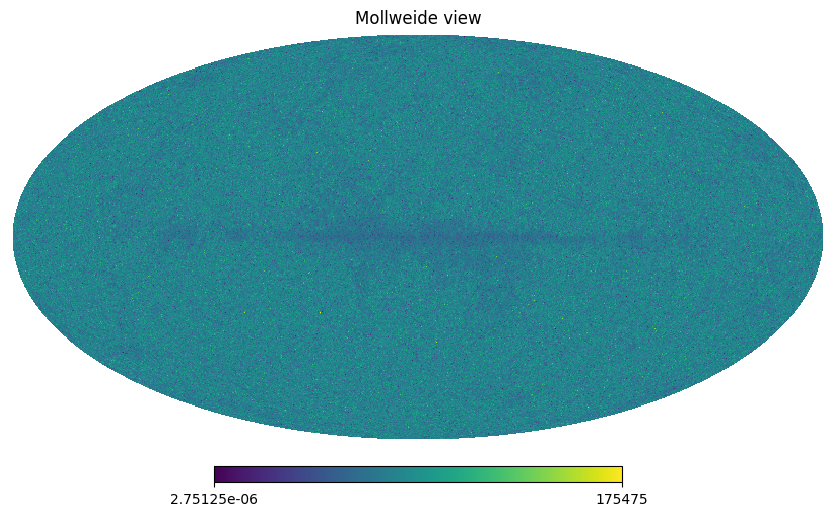

In [120]:
hp.mollview(np.abs((AS_p_inv-freq_maps_simple_noiseless2)[0,0]/freq_maps_simple_noiseless2[0,0]),norm = 'log')

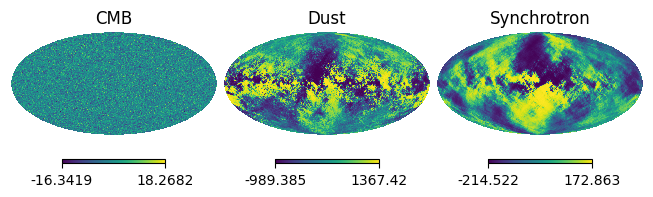

In [121]:
hp.mollview(result_basic_inv.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_basic_inv.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_basic_inv.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))


In [122]:
# hp.mollview(result_beam_smooth.s[0,1], title='CMB', sub=(1,3,1))
# hp.mollview(result_beam_smooth.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
# hp.mollview(result_beam_smooth.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

In [123]:
# hp.mollview(result_basic_ren.s[0,1], title='CMB', sub=(1,3,1))
# hp.mollview(result_basic_ren.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
# hp.mollview(result_basic_ren.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

Harmonic comp sep : from $a_{\ell m}$ to map

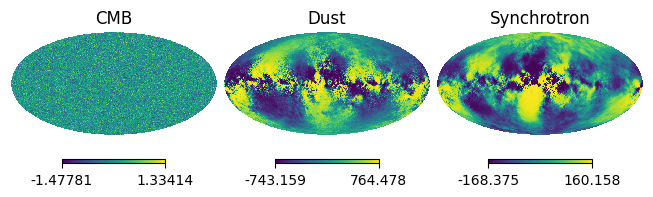

In [124]:
hp.mollview(hp.alm2map(result_harmo_inv.s[0,1],NSIDE,lmax), title='CMB', sub=(1,3,1))
hp.mollview(hp.alm2map(result_harmo_inv.s[1,1],NSIDE,lmax), title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(hp.alm2map(result_harmo_inv.s[2,1],NSIDE,lmax), title='Synchrotron', norm='hist', sub=(1,3,3))

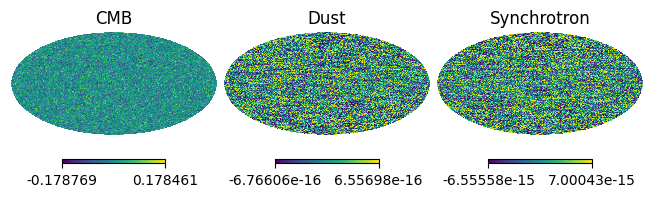

In [125]:
hp.mollview(hp.alm2map(result_harmo_ren.s[0,1],NSIDE,lmax), title='CMB', sub=(1,3,1))
hp.mollview(hp.alm2map(result_harmo_ren.s[1,1],NSIDE,lmax), title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(hp.alm2map(result_harmo_ren.s[2,1],NSIDE,lmax), title='Synchrotron', norm='hist', sub=(1,3,3))


# Retrieved Power spectrum

# Residuals

For harmonic comp sep

In [126]:
alm_CMB = hp.map2alm(map_CMB,lmax)
alm_CMB_smooth = hp.map2alm(map_CMB_smooth,lmax)

In [127]:
res_CMB_alm_inv = result_harmo_inv.s[0,0:2]-alm_CMB[1:3]
# res_CMB_alm_ren = result_harmo_ren.s[0,0:2]-alm_CMB_smooth[1:3]

In [128]:
print(map_CMB.shape)

(3, 3145728)


Basic component separation

In [129]:
res_CMB_map_inv = result_basic_inv.s[0]-map_CMB[1:3]
# res_CMB_map_ren = result_basic_ren.s[0]-map_CMB_smooth[1:3]

In [130]:
res_CMB_TEB_inv = np.zeros((3,npix),dtype=complex)
res_CMB_TEB_inv[1:3] = res_CMB_map_inv
print(res_CMB_TEB_inv.shape)

(3, 3145728)


In [131]:
res_CMB_TEB_ren = np.zeros((3,npix),dtype=complex)
# res_CMB_TEB_ren[1:3] = res_CMB_map_ren
print(res_CMB_TEB_ren.shape)

(3, 3145728)


In [132]:
C_l_res_basic_inv =hp.anafast(res_CMB_TEB_inv,lmax = lmax,alm=False,pol=True)
# C_l_res_basic_ren =hp.anafast(res_CMB_TEB_ren,lmax = lmax,alm=False,pol=True)
print(C_l_res_basic_inv.shape)

/home/julientang2001/.conda/envs/FGBuster_JT/lib/python3.11/site-packages/healpy/sphtfunc.py:274: ComplexWarning: Casting complex values to real discards the imaginary part
  alms = _sphtools.map2alm(


(6, 1025)


In [133]:
C_l_res_harmo_inv=hp.alm2cl(res_CMB_alm_inv,lmax=lmax)
# C_l_res_harmo_ren=hp.alm2cl(res_CMB_alm_ren,lmax=lmax)

# Retrieved CMB power spectra

In [134]:
ret_CMB_TEB_inv = np.zeros((3,npix),dtype=complex)
ret_CMB_TEB_inv[1:3] = result_basic_inv.s[0]
print(ret_CMB_TEB_inv.shape)

(3, 3145728)


In [135]:
# ret_CMB_TEB_ren = np.zeros((3,npix),dtype=complex)
# ret_CMB_TEB_ren[1:3] = result_basic_ren.s[0]
# print(ret_CMB_TEB_ren.shape)

In [136]:
C_l_ret_basic_inv =hp.anafast(ret_CMB_TEB_inv,lmax = lmax,alm=False,pol=True)
# C_l_ret_basic_ren =hp.anafast(ret_CMB_TEB_ren,lmax = lmax,alm=False,pol=True)
print(C_l_ret_basic_inv.shape)

(6, 1025)


In [137]:
C_l_ret_harmo_inv=hp.alm2cl(result_harmo_inv.s[0],lmax=lmax)
# C_l_ret_harmo_ren=hp.alm2cl(result_harmo_ren.s[0],lmax=lmax)

# + Gravitational waves

In [138]:
cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

map_CMB_GW = hp.synfast(cl_GW,nside=NSIDE)

(4, 4101)
(4, 1025)


In [139]:
cl_tot_th = np.add(0.001*cl_GW_crop,cl_CMB)

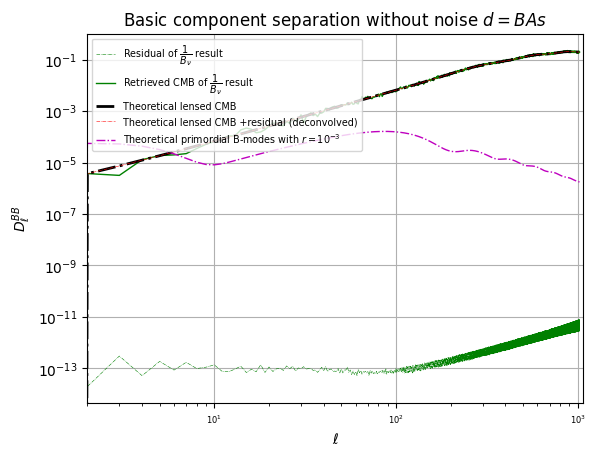

In [140]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
ax1.plot(l_arr,D_ell(C_l_res_basic_inv[2]),'g-.',linewidth =.4,label = 'Residual of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_ret_basic_inv[2]),'g-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{1}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(C_l_res_basic_ren[2]),'b-.',linewidth =.4,label = 'Residual of $\dfrac{B^c}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(C_l_ret_basic_ren[2]),'b-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{B^c}{B_{\\nu}}$ result')
py.title('Basic component separation without noise $d=BAs$')

ax1.plot(l_arr,l_arr*(l_arr+1)*cl_CMB_crop_th[2]/np.pi,'k-.',linewidth =2,label = "Theoretical lensed CMB ")
ax1.plot(l_arr,D_ell(C_l_res_basic_inv[2]+cl_CMB_crop_th[2]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (deconvolved)")
# ax1.plot(l_arr,D_ell(C_l_res_basic_ren[2]+cl_CMB_crop_th[2]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (reconvolved)")



ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 #,right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")


py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

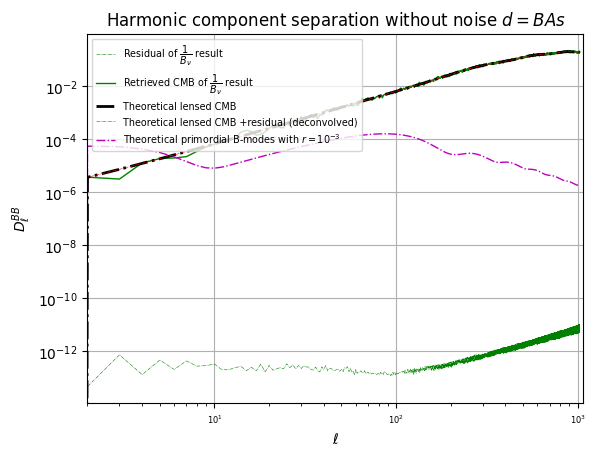

In [141]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
ax1.plot(l_arr,D_ell(C_l_res_harmo_inv[1]),'g-.',linewidth =.4,label = 'Residual of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_ret_harmo_inv[1]),'g-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{1}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(C_l_res_harmo_ren[1]),'b-.',linewidth =.4,label = 'Residual of $\dfrac{B^c}{B_{\\nu}}$ result')
# ax1.plot(l_arr,D_ell(C_l_ret_harmo_ren[1]),'b-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{B^c}{B_{\\nu}}$ result')
py.title('Harmonic component separation without noise $d=BAs$')

ax1.plot(l_arr,l_arr*(l_arr+1)*cl_CMB_crop_th[2]/np.pi,'k-.',linewidth =2,label = "Theoretical lensed CMB ")
ax1.plot(l_arr,D_ell(C_l_res_harmo_inv[1]+cl_CMB_crop_th[2]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (deconvolved)")
# ax1.plot(l_arr,D_ell(C_l_res_harmo_ren[1]+cl_CMB_crop_th[2]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (reconvolved)")


ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 #,right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")


py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

### Cosmological parameters

In [142]:
def cosmo_likelihood(r,C_l_obs,noise):
    if len(C_l_obs)!=lmax+1 or len(noise)!=lmax+1:
        raise Warning("Arrays should be of size "+str(lmax))
    
    C_lth =r*cl_GW_crop[2]+cl_CMB_crop_th[2]+noise
    sig = 0
    for l in range(2,lmax):
        sig+=(2*l+1)*(np.log(C_lth[l])+C_l_obs[l]/C_lth[l])
    return (sig)
